In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

data = data[:,1:]

# normalize the data to a range of [-1, 1]
dataNorm = data/np.max(data)
dataNorm = 2* dataNorm - 1

# convert to tensor
dataT = torch.tensor(dataNorm).float()

batchsize = 100


In [ ]:
dataT.shape

torch.Size([20000, 784])

In [ ]:
class discriminatorNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, x):

        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)

        return torch.sigmoid(x)
dnet = discriminatorNet()
y = dnet(torch.randn(10, 784))
y

tensor([[0.4859],
        [0.4719],
        [0.4515],
        [0.4652],
        [0.5156],
        [0.4425],
        [0.4785],
        [0.4794],
        [0.4526],
        [0.4598]], grad_fn=<SigmoidBackward0>)

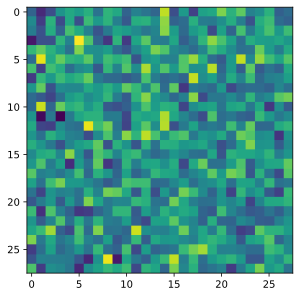

In [ ]:
class generatorNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 784)

    def forward(self, x):

        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)

        return torch.tanh(x)

gnet = generatorNet().to(device)
y = gnet(torch.randn(10, 64).to(device)).cpu()

plt.imshow(y[0, :].detach().squeeze().view(28,28))

In [ ]:
lossfun = nn.BCELoss()

# create instances of the model
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers
d_optimizer = torch.optim.Adam(dnet.parameters(), lr = .0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr = .0003)


In [ ]:
num_epochs = 50000

losses = np.zeros((num_epochs, 2))
disDecs = np.zeros((num_epochs, 2))

for epochi in range(num_epochs):
    randidx = torch.randint(dataT.shape[0], (batchsize, ))
    real_images = dataT[randidx, :].to(device)
    fake_images = gnet(torch.randn(batchsize, 64).to(device))

    # labels for real and fake images
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)



    #### Train the Discriminator

    # forward pass and loss for REAL pictures
    pred_real = dnet(real_images)
    d_loss_real = lossfun(pred_real, real_labels)

    pred_fake = dnet(fake_images)
    d_loss_fake = lossfun(pred_fake, fake_labels)

    d_loss = d_loss_real + d_loss_fake

    losses[epochi, 0] = d_loss.item()
    disDecs[epochi, 0] = torch.mean((pred_real > .5).float()).detach()


    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()



    # Train the generator
    fake_images = gnet(torch.randn(batchsize, 64).to(device))
    pred_fake = dnet(fake_images)

    # compute and collect loss and accuracy
    g_loss = lossfun(pred_fake, real_labels)
    losses[epochi, 1] = g_loss.item()
    disDecs[epochi, 1] = torch.mean((pred_fake > .5).float()).detach()

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if (epochi + 1)% 500 == 0:
        msg = f'Finished Epoch {epochi + 1}/{num_epochs}'
        sys.stdout.write('\r' + msg)




Finished Epoch 50000/50000

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (19, 6))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discriminator', 'Generator'])
# ax[0].set_xlim([4000, 6000])


ax[1].plot(losses[::5, 0], losses[::5, 1], 'k.', alpha = .1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probability("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real', 'Fake'])

plt.show()




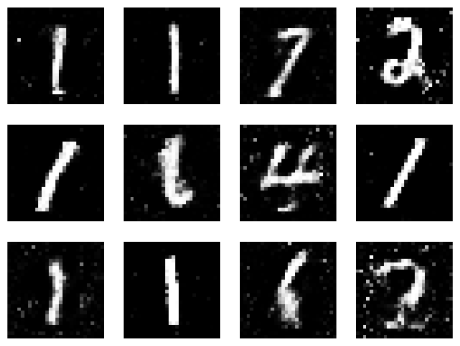

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()